In [2]:
import torch
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from csibert_util import CSIBERT  # Your CSIBERT implementation
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns

import os
from pdf2image import convert_from_path
from PIL import Image

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
# Load CSI data
cell_data = scipy.io.loadmat('foundation_model_data/csi_data_massive_mimo_test.mat')['multi_cell_csi']

# Preprocessing Function
def preprocess_csi_matrix(csi_matrix):
    csi_real = np.real(csi_matrix)
    csi_imag = np.imag(csi_matrix)
    csi_real_normalized = (csi_real - np.mean(csi_real)) / np.std(csi_real)
    csi_imag_normalized = (csi_imag - np.mean(csi_imag)) / np.std(csi_imag)
    csi_combined = np.stack([csi_real_normalized, csi_imag_normalized], axis=-1)
    time_dim = csi_combined.shape[0]
    feature_dim = np.prod(csi_combined.shape[1:])
    return csi_combined.reshape(time_dim, feature_dim)

# Process and Pad Data
preprocessed_data = []
sequence_lengths = []
for cell_idx in range(cell_data.shape[0]):
    for ue_idx in range(cell_data.shape[1]):
        ue_data = cell_data[cell_idx, ue_idx]
        for scenario in ue_data[0]:
            processed_csi = preprocess_csi_matrix(scenario)
            preprocessed_data.append(processed_csi)
            sequence_lengths.append(processed_csi.shape[0])

max_sequence_length = max(sequence_lengths)
feature_dim = preprocessed_data[0].shape[-1]

padded_data = np.zeros((len(preprocessed_data), max_sequence_length, feature_dim), dtype=np.float32)
attention_masks = np.zeros((len(preprocessed_data), max_sequence_length), dtype=np.float32)
for i, sequence in enumerate(preprocessed_data):
    seq_len = sequence.shape[0]
    padded_data[i, :seq_len, :] = sequence
    attention_masks[i, :seq_len] = 1  # Valid data mask


In [6]:
# Load the trained model
checkpoint_path = "checkpoints/best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
feature_dim = checkpoint["feature_dim"]

# Initialize CSIBERT model
model = CSIBERT(feature_dim=feature_dim)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Move the model to MPS
model.eval()
print("Model loaded successfully.")


Model loaded successfully.


# Reconstruction Error

In [5]:
# Prepare Dataset
masked_data = np.copy(padded_data)
masked_data[:, ::10, :] = 0  # Mask every 10th sample for evaluation

test_dataset = TensorDataset(
    torch.tensor(masked_data).float(),
    torch.tensor(padded_data).float()
)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate Model
mse_errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
        mse_errors.append(mse)

# Average MSE
avg_mse = np.mean(mse_errors)
print(f"Reconstruction MSE: {avg_mse:.6f}")


Reconstruction MSE: 0.011035


# Experiment 2 - Scenario-wise Performance

In [6]:
# Compute MSE for each scenario
scenario_mse = []
scenario_names = ['Stationary', 'High-Speed', 'Urban Macro']

for scenario_idx in range(3):
    # Select every 3rd sample for each scenario
    scenario_data = masked_data[scenario_idx::3]
    labels = padded_data[scenario_idx::3]

    with torch.no_grad():
        # Ensure data is on the same device as the model
        inputs = torch.tensor(scenario_data).float().to(device)
        labels = torch.tensor(labels).float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute MSE
        mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
        scenario_mse.append(mse)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Scenario': scenario_names,
    'MSE': scenario_mse
})
results_df

,Scenario,MSE
0,Stationary,0.003185
1,High-Speed,0.003179
2,Urban Macro,0.026609


# Experiment 3 - Masking Ratio Sensitivity

In [7]:
# Function to apply masking to the data
def mask_data(data, mask_ratio=0.15):
    """
    Masks a random portion of the data for the masked signal prediction task.
    """
    mask = np.random.rand(*data.shape[:-1]) < mask_ratio  # Generate mask for all but the last dimension
    masked_data = np.copy(data)
    masked_data[mask, :] = 0  # Replace masked elements with 0
    return masked_data, mask


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/rh/1c0lrj_x0x956417g86lc4ph0000gn/T/ipykernel_78087/2193968771.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=results_df, x='Masking Ratio', y='MSE', ci='sd', err_style="band")


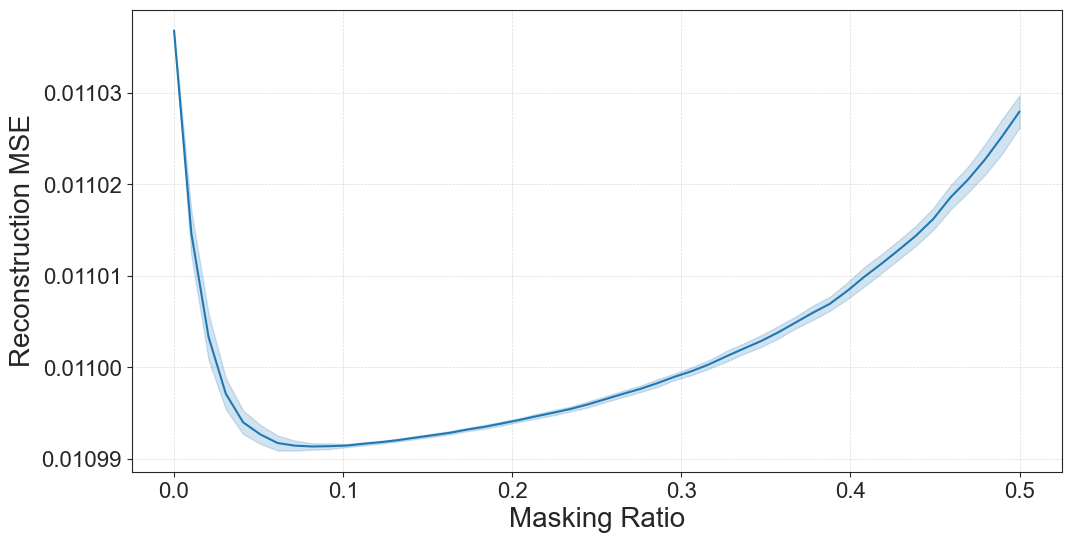

In [8]:
# Masking Ratios to Experiment With
mask_ratios = np.linspace(0.0, 0.5, 50)
num_trials = 100  # Number of times to repeat the experiment

# Prepare a DataFrame to store results
results = []

# Perform experiments
for trial in tqdm(range(num_trials), desc="Trials"):
    for ratio in mask_ratios:
        # Mask data with the current ratio
        masked_data, _ = mask_data(padded_data, mask_ratio=ratio)

        # Evaluate model performance
        with torch.no_grad():
            # Move tensors to the same device as the model
            inputs = torch.tensor(masked_data).float().to(device)
            labels = torch.tensor(padded_data).float().to(device)
            
            # Ensure model is on the same device
            model.to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute MSE
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())

        # Store the result
        results.append({'Masking Ratio': ratio, 'MSE': mse, 'Trial': trial})

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("ticks")  # Use a clean style with ticks

sns.lineplot(data=results_df, x='Masking Ratio', y='MSE', ci='sd', err_style="band")
plt.xlabel("Masking Ratio", fontsize=20)
plt.ylabel("Reconstruction MSE", fontsize=20)
#plt.title("Effect of Masking Ratio on Reconstruction (20 Trials)")
sns.set_style("ticks")
# Enable gridlines explicitly using Matplotlib
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/masking_ratio_vs_mse.pdf", dpi=300, bbox_inches='tight')

plt.show()


# Experiment 4 - Attention Visualization

In [9]:
# Create directory to save images if it doesn't exist
output_dir = "imgs"
os.makedirs(output_dir, exist_ok=True)

# Perform the experiment 10 times
num_experiments = 10
for experiment in range(1, num_experiments + 1):
    # Randomly select a sample index
    sample_idx = np.random.randint(0, len(padded_data) - 1)
    
    # Extract sample input and attention mask
    sample_input = padded_data[sample_idx:sample_idx + 1]
    attention_mask = attention_masks[sample_idx:sample_idx + 1]

    # Convert to tensor and move to device
    sample_input_tensor = torch.tensor(sample_input).float().to(device)
    attention_mask_tensor = torch.tensor(attention_mask).float().to(device)

    # Get predictions and attention weights
    with torch.no_grad():
        predictions, attentions = model(sample_input_tensor, attention_mask_tensor, output_attentions=True)

    # Visualize attention for a specific layer and head
    layer_idx = 11  # Last layer
    head_idx = 0    # First head

    attention_weights = attentions[layer_idx][0, head_idx].cpu().numpy()  # Shape: (sequence_length, sequence_length)

    # Plot heatmap
    plt.figure(figsize=(9, 7))
    sns.heatmap(attention_weights, cmap="viridis", square=True)
    plt.xlabel("Input Sequence", fontsize=25)
    plt.ylabel("Output Sequence", fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=19)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=19)  # Minor ticks (if any)

    # Save the image
    output_path = os.path.join(output_dir, f"attention_visualization_experiment_{experiment}.pdf")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Experiment {experiment}: Visualization saved to {output_path}")

print("All attention visualizations saved.")

Experiment 1: Visualization saved to imgs/attention_visualization_experiment_1.pdf
Experiment 2: Visualization saved to imgs/attention_visualization_experiment_2.pdf
Experiment 3: Visualization saved to imgs/attention_visualization_experiment_3.pdf
Experiment 4: Visualization saved to imgs/attention_visualization_experiment_4.pdf
Experiment 5: Visualization saved to imgs/attention_visualization_experiment_5.pdf
Experiment 6: Visualization saved to imgs/attention_visualization_experiment_6.pdf
Experiment 7: Visualization saved to imgs/attention_visualization_experiment_7.pdf
Experiment 8: Visualization saved to imgs/attention_visualization_experiment_8.pdf
Experiment 9: Visualization saved to imgs/attention_visualization_experiment_9.pdf
Experiment 10: Visualization saved to imgs/attention_visualization_experiment_10.pdf
All attention visualizations saved.


# Experiment 5 - Performance Across Subcarriers

In [10]:
# Divide subcarriers into smaller groups for detailed analysis
subcarrier_groups = [(i, i + 7) for i in range(0, 64, 8)]  # 8 subcarriers per group

In [11]:
from sklearn.metrics import mean_squared_error

# Ensure model is on the same device as inputs
model.to(device)

# Initialize lists to store metrics
subcarrier_mse = []
subcarrier_std = []
subcarrier_max_error = []

for group in subcarrier_groups:
    group_data = padded_data[:, group[0]:group[1] + 1, :]  # Select subcarriers in the range
    masked_group_data, _ = mask_data(group_data, mask_ratio=0.15)

    errors = []
    with torch.no_grad():
        # Move inputs and labels to the same device as the model
        inputs = torch.tensor(masked_group_data).float().to(device)
        labels = torch.tensor(group_data).float().to(device)
        
        # Forward pass
        outputs = model(inputs)

        # Compute errors
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

    # Calculate metrics
    mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
    std = np.std(errors)
    max_error = np.max(np.abs(errors))

    subcarrier_mse.append(mse)
    subcarrier_std.append(std)
    subcarrier_max_error.append(max_error)

# Create a DataFrame with the metrics
subcarrier_df = pd.DataFrame({
    'Subcarrier Group': [f'{group[0]}-{group[1]}' for group in subcarrier_groups],
    'MSE': subcarrier_mse,
    'STD of Error': subcarrier_std,
    'Max Error': subcarrier_max_error
})
subcarrier_df

,Subcarrier Group,MSE,STD of Error,Max Error
0,0-7,0.012956,0.113823,0.822429
1,8-15,0.075252,0.274228,5.393202
2,16-23,0.074781,0.273373,5.561967
3,24-31,0.075120,0.273994,5.528120
4,32-39,0.076423,0.276358,5.570692
5,40-47,0.077504,0.278302,5.624196
6,48-55,0.079439,0.281757,5.476225
7,56-63,0.080906,0.284343,5.701845


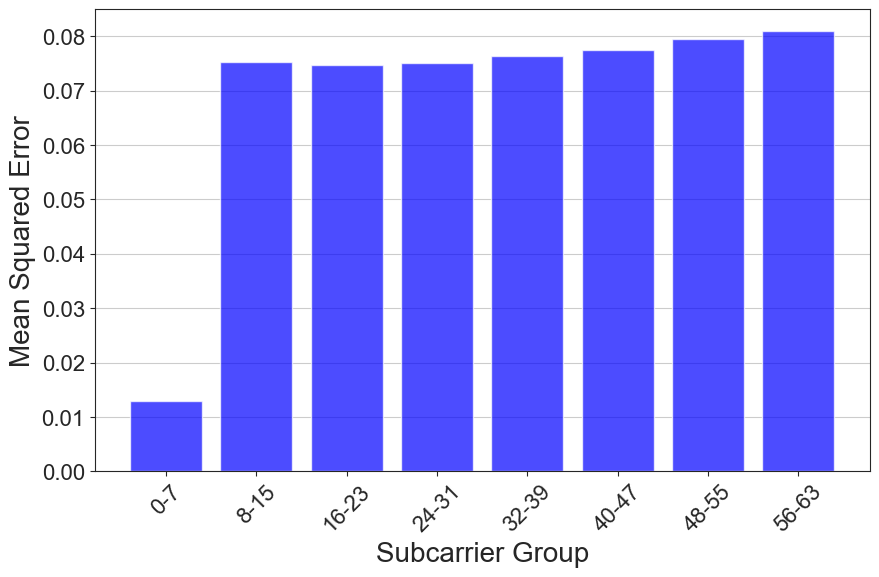

In [12]:
# Plot MSE for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['MSE'], color='blue', alpha=0.7)
plt.xlabel("Subcarrier Group", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
# plt.title("Reconstruction MSE Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/reconstruction_mse_across_subcarrier_groups.pdf", dpi=300, bbox_inches='tight')
plt.show()


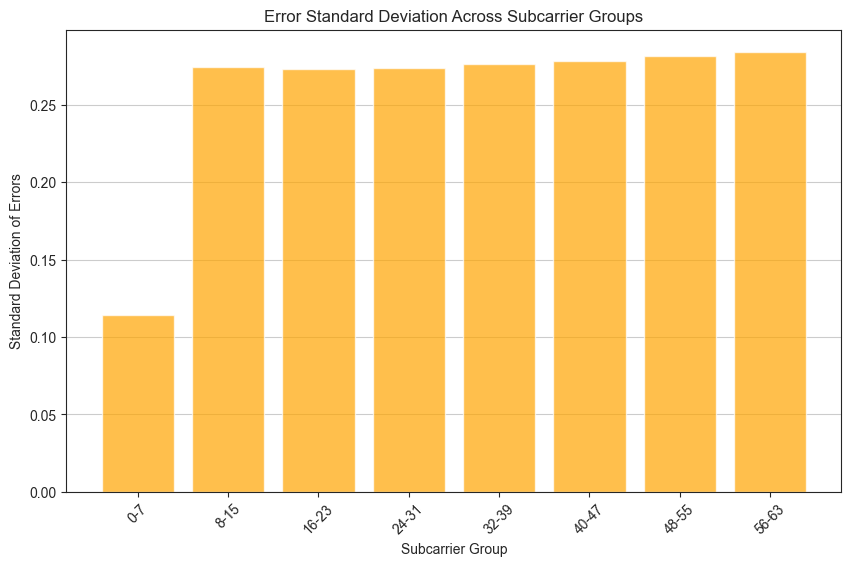

In [13]:
# Plot standard deviation of errors for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['STD of Error'], color='orange', alpha=0.7)
plt.xlabel("Subcarrier Group")
plt.ylabel("Standard Deviation of Errors")
plt.title("Error Standard Deviation Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


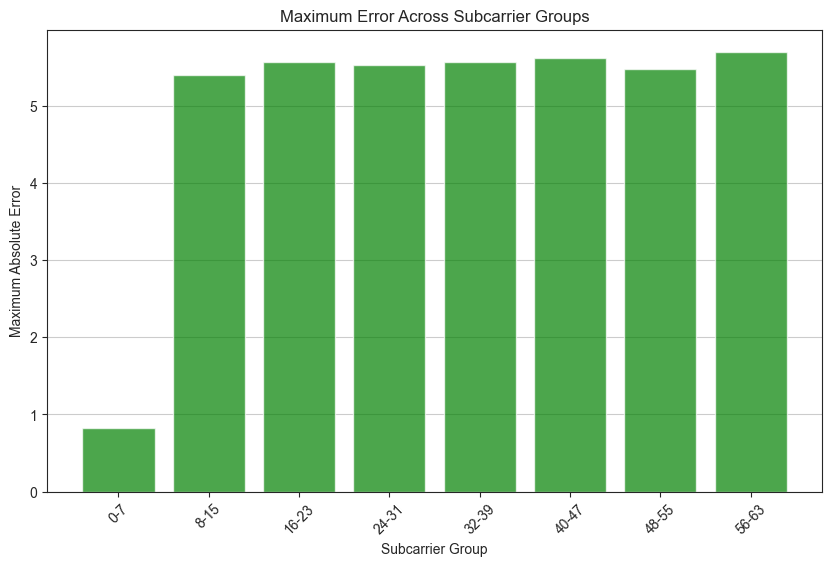

In [14]:
# Plot maximum error for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['Max Error'], color='green', alpha=0.7)
plt.xlabel("Subcarrier Group")
plt.ylabel("Maximum Absolute Error")
plt.title("Maximum Error Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


# Experiment 6 - Error Distribution Analysis

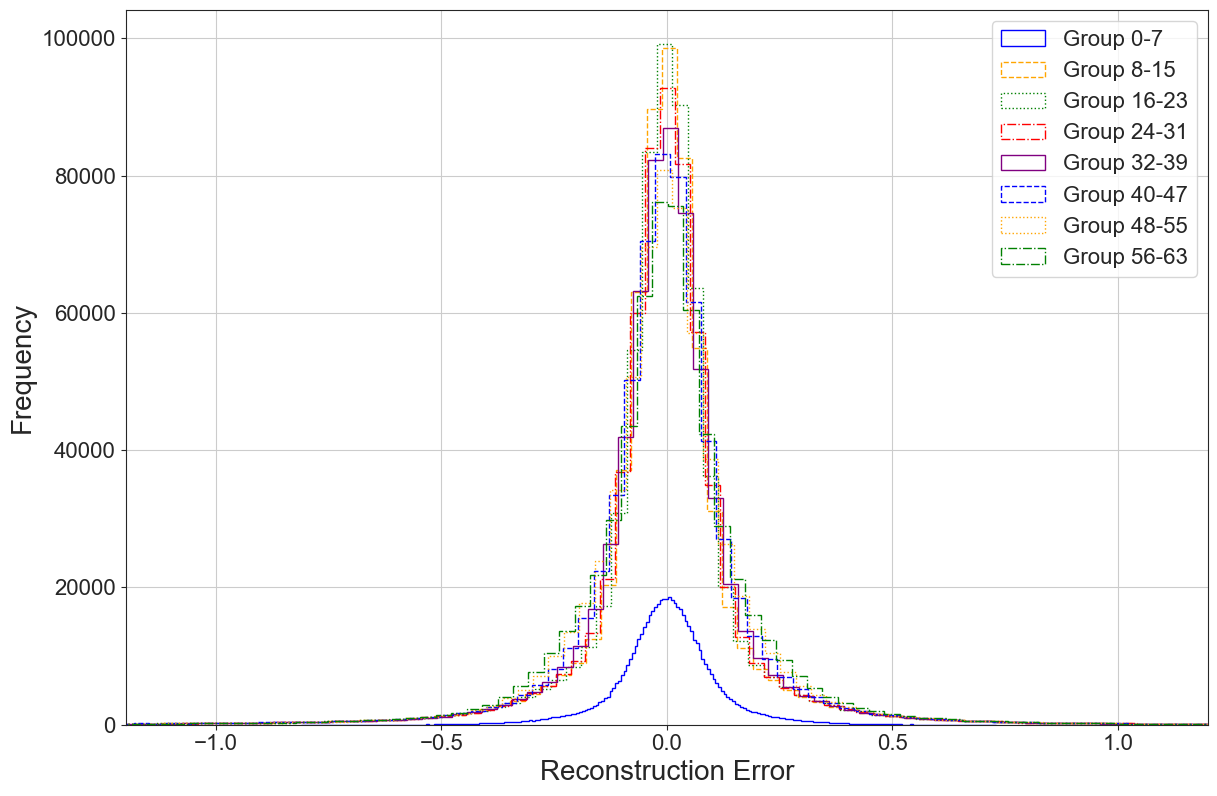

In [15]:
# Error Distribution Across All Subcarrier Groups
plt.figure(figsize=(12, 8))

linestyles = ['solid', 'dashed', 'dotted', 'dashdot']  # Define a variety of line styles
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define a variety of colors

for idx, group in enumerate(subcarrier_groups):  # Iterate over all subcarrier groups
    group_data = padded_data[:, group[0]:group[1] + 1, :]
    masked_group_data, _ = mask_data(group_data, mask_ratio=0.15)

    errors = []
    with torch.no_grad():
        # Move inputs and labels to the device
        inputs = torch.tensor(masked_group_data).float().to(device)
        labels = torch.tensor(group_data).float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute errors
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

    # Plot the error distribution for each subcarrier group with different styles
    plt.hist(
        errors,
        bins=250,
        histtype='step',
        linestyle=linestyles[idx % len(linestyles)],  # Cycle through linestyles
        color=colors[idx % len(colors)],  # Cycle through colors
        label=f"Group {group[0]}-{group[1]}"
    )

# Add labels and title
plt.xlabel("Reconstruction Error", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
# plt.title("Error Distribution Across All Subcarrier Groups")
plt.legend(loc='upper right', fontsize='small', prop={'size': 16})
plt.grid()
plt.tight_layout()
plt.xlim([-1.2, 1.2])

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

# Save the figure
plt.savefig("imgs/error_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()


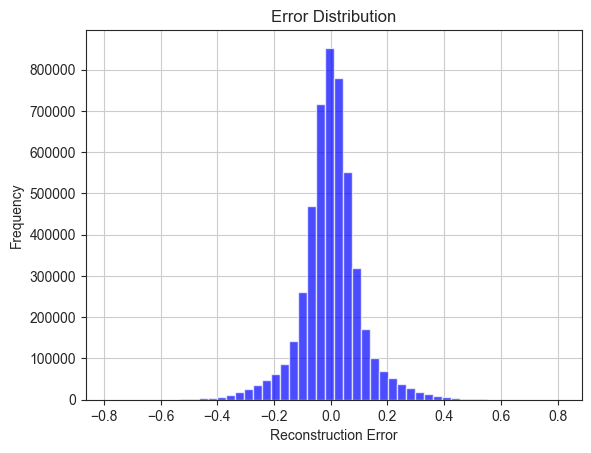

In [16]:
# Compute errors for all samples
errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Move tensors to CPU before converting to NumPy
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

# Plot error distribution
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid()
plt.show()


# Experiment 7 - Attention Mechanism Behavior

# Experiment 8 - Baseline Comparison

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Baseline models
linear_model = LinearRegression()
mlp_model = MLPRegressor(hidden_layer_sizes=(512,), max_iter=1000, random_state=42)

# Prepare training data
train_inputs = masked_data.reshape(-1, feature_dim)
train_labels = padded_data.reshape(-1, feature_dim)

# Train models
linear_model.fit(train_inputs, train_labels)
mlp_model.fit(train_inputs, train_labels)

# Evaluate models
baseline_mse = {
    'CSIBERT': avg_mse,
    'Linear Regression': mean_squared_error(train_labels, linear_model.predict(train_inputs)),
    'MLP': mean_squared_error(train_labels, mlp_model.predict(train_inputs))
}

# Create a table
baseline_df = pd.DataFrame({
    'Model': list(baseline_mse.keys()),
    'MSE': list(baseline_mse.values())
})
baseline_df

,Model,MSE
0,CSIBERT,0.011035
1,Linear Regression,0.309207
2,MLP,0.314465


# Experiment 9 - Impact of Doppler Shift

In [ ]:
# Set up Seaborn for plotting
sns.set(style="whitegrid")

# Define Doppler shifts and initialize storage for results
doppler_shifts = np.linspace(50.0, 400.0, 32).round()  # Define 8 Doppler shifts
num_experiments = 100  # Number of experiments
results = []  # To store results across experiments

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform the experiment
for experiment in tqdm(range(num_experiments), desc="Experiments"):
    for doppler in doppler_shifts:
        # Add artificial noise to simulate Doppler effect
        noisy_data = padded_data + np.random.normal(0, doppler / 1000, padded_data.shape)

        # Ensure noisy_data is on the correct device
        with torch.no_grad():
            inputs = torch.tensor(noisy_data).float().to(device)  # Move to device
            labels = torch.tensor(padded_data).float().to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            
            # Move tensors back to CPU for evaluation
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())

        # Append results
        results.append({'Experiment': experiment + 1, 'Doppler Shift (Hz)': doppler, 'MSE': mse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Doppler Shift (Hz)',
    y='MSE',
    #hue='Experiment',
    errorbar='sd',  # Standard deviation as error bars
    err_style="band"
)
plt.xlabel("Doppler Shift (Hz)", fontsize=20)
plt.ylabel("Reconstruction MSE", fontsize=20)
#plt.title("Impact of Doppler Shift on Reconstruction MSE Across 10 Experiments")

sns.set_style("ticks")
# Enable gridlines explicitly using Matplotlib
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/impact_of_doppler_shift.pdf", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

# Experiment 10 - Generalization Across Scenarios

   Train Scenario  Test Scenario       MSE
0               0              0  0.003185
1               0              1  0.003182
2               0              2  0.026611
3               1              0  0.003185
4               1              1  0.003182
5               1              2  0.026610
6               2              0  0.003185
7               2              1  0.003181
8               2              2  0.026610


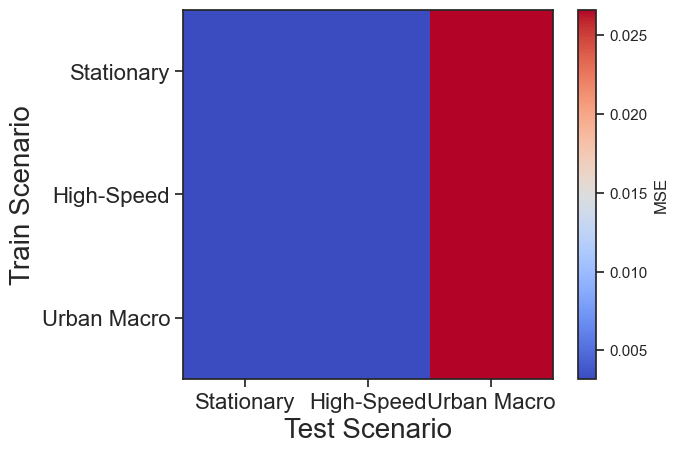

In [19]:
# Cross-scenario evaluation
cross_mse = []
for train_scenario_idx in range(3):  # Assuming 3 scenarios
    for test_scenario_idx in range(3):
        # Train on one scenario
        train_data = padded_data[train_scenario_idx::3]
        train_masked, _ = mask_data(train_data, mask_ratio=0.15)

        # Test on another scenario
        test_data = padded_data[test_scenario_idx::3]
        test_masked, _ = mask_data(test_data, mask_ratio=0.15)

        # Evaluate
        with torch.no_grad():
            inputs = torch.tensor(test_masked).float().to(device)
            labels = torch.tensor(test_data).float().to(device)
            outputs = model(inputs)
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
            cross_mse.append((train_scenario_idx, test_scenario_idx, mse))

# Create a DataFrame
cross_df = pd.DataFrame(cross_mse, columns=['Train Scenario', 'Test Scenario', 'MSE'])
print(cross_df)

# Visualize
cross_pivot = cross_df.pivot(index='Train Scenario', columns='Test Scenario', values='MSE')
plt.imshow(cross_pivot.values, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="MSE")
# plt.title("Cross-Scenario Generalization")
plt.xlabel("Test Scenario", fontsize=20)
plt.ylabel("Train Scenario", fontsize=20)
plt.xticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'])  # Update labels as needed
plt.yticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'])  # Update labels as needed

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/generalization_across_scenarios.pdf", dpi=300, bbox_inches='tight')

plt.show()
